In [1]:
import pandas as pd
#from binance.spot import Spot as Client
from binance.client import Client
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import ta

In [38]:
import algo.calculate_short

In [31]:
import importlib, data.read
importlib.reload(data.read)
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

In [50]:
df_all = data.read.df_okx_20231220_1225

### backtest algo

In [5]:
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

In [7]:
def describe_backtest(data_dict, trades, open_trades, portfolio_value):
    # Sort trades DataFrame by 'Entry Date'
    trades.sort_values(by='Entry Date', inplace=True)
    # Create a figure for individual portfolio plots
    plt.figure(figsize=(12, 8))
    
    # Configure the individual portfolio plot
    plt.title('Individual Portfolio Performance by Asset')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    
    # Initialize a DataFrame to store aligned portfolio values for all assets
    all_portfolios = pd.DataFrame()
    
    # Plot portfolio value for each asset and align for average	calculation
    for asset, df in data_dict.items():
        if df['portfolio'].iloc[-1] == df['portfolio'].iloc[0]:
            continue
        plt.plot(df['date'], df['portfolio'], label=f'{asset}')
        all_portfolios[asset] = df.set_index('date')['portfolio'] - portfolio_value
    #all_portfolios.fillna(float(portfolio_value / len(data_dict)), inplace=True)
    all_portfolios.fillna(method='ffill', inplace=True)
    
    plt.legend()
    plt.grid(True)
    plt.show() # Show the plot for individual portfolios
    
    # Create a new figure for the average portfolio plot
    plt.figure(figsize=(12, 8))
    # Calculate the average portfolio value
    all_portfolios['Average Portfolio'] = all_portfolios.sum(axis=1)
    # Plot the average portfolio value
    plt.plot(all_portfolios.index, all_portfolios['Average Portfolio'], label='Average Portfolio', color='black', linewidth=2)
    
    # Configure the average portfolio plot
    plt.title('Average Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Average Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return all_portfolios

### apply backtest to okx 1minutes data

In [39]:
importlib.reload(algo.calculate_short)

<module 'algo.calculate_short' from '/home/junlim/projects/kristjan_swing/algo/calculate_short.py'>

In [43]:
def strategy_short_backtest_from_df(df_all, position_size, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase):
    trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Dollar Return', 'Outcome'])
    open_trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Entry Price', 'Current Price', 'Stop Loss', 'Potential Dollar Return'])
    data_dict = {}
    
    for asset, df in df_all.groupby('asset'):
        df, new_trades, new_open_trades = algo.calculate_short.trade_asset(asset, df.reset_index().drop('index', axis=1), position_size, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)
        data_dict[asset] = df
        trades = pd.concat([trades, new_trades], ignore_index=True)
        open_trades = pd.concat([open_trades, new_open_trades], ignore_index=True)

    return data_dict, trades, open_trades

In [40]:
# Initial value of the trading portfolio in dollars
portfolio_value = 100000
# Maximum percentage of the portfolio value to risk on a single trade
risk_trade_percentage = 1
# Minimum number of days for an asset to be considered in a consolidation period
min_days_in_consolidation = 7
# Maximum number of days for an asset to remain in the consolidation period
max_days_in_consolidation = 56
# Minimum percentage increase in asset price to consider for trading
min_perc_increase = 3

In [51]:
data_dict_3, closed_trades_3, open_trades_3 = strategy_short_backtest_from_df(df_all, int(portfolio_value / 10), risk_trade_percentage, 3, max_days_in_consolidation, -3)

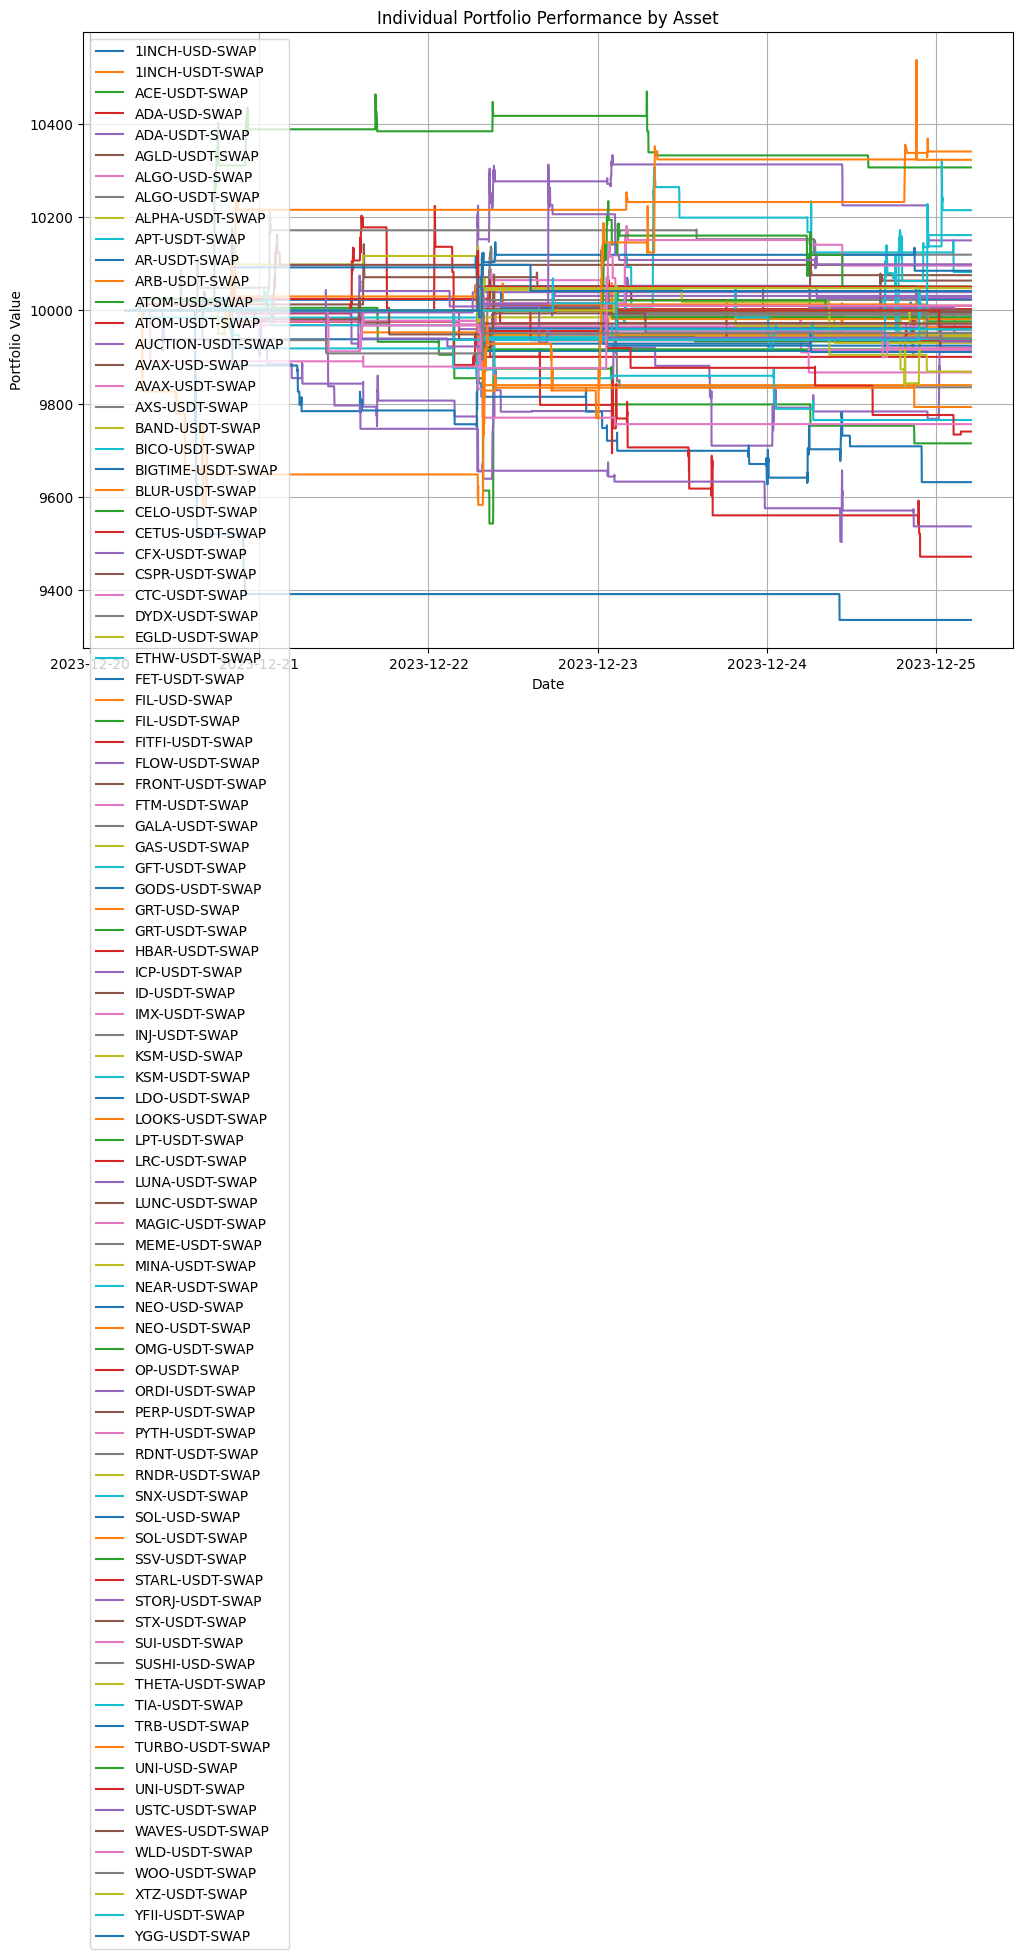

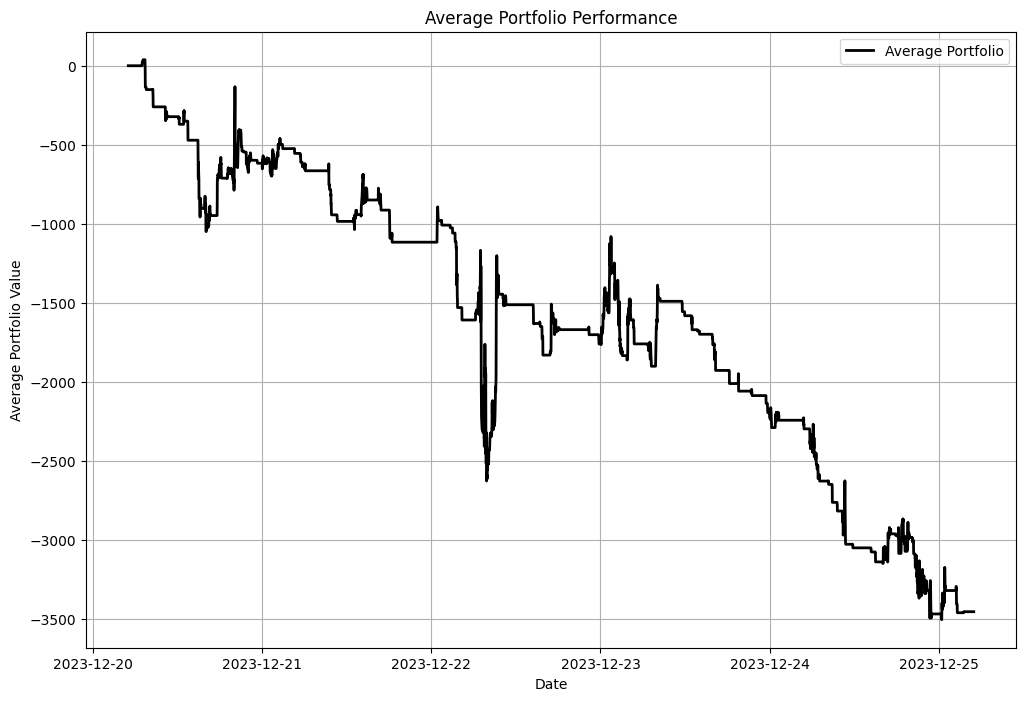

In [52]:
# min_perc_increase = 3
all_portfolios_ = describe_backtest(data_dict_3, closed_trades_3, open_trades_3, float(portfolio_value / 10))